In [1]:
#2 stage rocket simulation around kerbin(analog for earth in kerbal space program game)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as sci #integration toolbox

In [2]:
#equations of motion for flat earth surface
#F= m*a = m*zdd where z = altitute from center of planet along north pole , zd = velocity along z and zdd = acceleration along z
#x is the altitude along equator through Africa
rplanet = 600000 #radius of kerbin (m)
mplanet = 5.2915158*10**22 #mass of kerbin (kg)
g = 6.6742*10**-11 #gravitational constant (SI units)

#for rocket
wtons = 5.3 #weight of rocket in tons
mass0 = wtons*2000/2.2 #initial mass in kg
max_thrust = 167970 #newtons
isp1 = 250 #seconds #specific impulse to show how well a rocket performs
isp2 = 400
tmeco = 38 #time for main engine to cutoff
tsep1 = 2 #length of time to remove 1st stage
mass1tons = 0.2
mass1 = mass1tons*2000/2.2
t2start = 261 #starting time of burning second stage (sec)
t2end = t2start + 17.5


#gravitational acceleration model
def gravity(x, z): #this is 2D where z is along north pole and x is along the equator
    global rplanet, mplanet
    r = np.sqrt(x**2 + z**2)
    if r < 0:
        accx = 0
        accz = 0
    else:
        accx = g*mplanet/(r**3)*x
        accz = g*mplanet/(r**3)*z
    return np.asarray([accx, accz])

#adding a thrust model
def propulsion(t): #based on time but it is not the usual way to just have a stopwatch and fire on regular intervals
    global max_thrust, isp, tmeco
    #timing for thrusters
    if t < tmeco:
        #we are firing the main thruster
        theta = 10*np.pi/180 #angle of thrust of 10 degrees
        ve = isp1*9.81 #exit velocity
        thrustf = max_thrust
        md = -thrustf/ve #md needs to be -ve as rocket is losing mass
    if t > tmeco and t < (tmeco + tsep1): #tsep1 is the time for 1 stage to separate
        theta = 0
        thrustf = 0
        #mass lost
        md = -mass1/tsep1
    if t > (tmeco + tsep1):
        theta = 0
        thrustf = 0
        md = 0
    if t > (t2start) and t < (t2end):
        theta = 90*np.pi/180 #firing sideways
        ve = isp2*9.81 #exit velocity
        thrustf = max_thrust
        md = -thrustf/ve 
    if t > t2end:
        theta = 0
        thrustf = 0
        md = 0
    
    thrustx = thrustf*np.cos(theta)
    thrustz = thrustf*np.sin(theta)
    
    return np.asarray([thrustx, thrustz]), md
    
#second order differential equation 
def Derivatives(state, t):
    x = state[0] #1st row of state vector
    z = state[1] #2nd row of state vector
    velx = state[2]
    velz = state[3]
    mass = state[4]

    #kinematics equations
    zd = velz #derivative of position is velocity
    xd = velx
    #computing total forces
    gravf = -gravity(x, z)*mass #this is newtonian gravity and z needs to be in reference with the center of planet 
    aerof = np.asarray([0, 0]) #aerodynamics
    thrustf, md = propulsion(t)
    Forces = gravf + aerof + thrustf
    if mass > 0:
        dd = Forces/mass
    else:
        dd = 0
        md = 0
    #compute stated
    stated = np.asarray([xd, zd, dd[0], dd[1], md]) #[derivative of velx, derivative of velz, array of dd]

    return stated

In [3]:
#testing surface gravity
print("Surface gravity (m/s^2) = ", gravity(0, rplanet))

'''intial conditions for orbit
x0 = rplanet + 600000 #with reference to center of earth #in meters and 600000 meters is because the spacecraft is beyond the radius of planet
z0 = 0
r0 = np.sqrt(x0**2 + z0**2)
velz0 = np.sqrt(g*mplanet/r0)*1.1 #in m/s
velx0 = 0 
period = 2*np.pi/np.sqrt(g*mplanet)*r0**(3/2)*1.5 #kepler equation to tell how long orbit takes
'''

#inital conditions for single stage rocket
x0 = rplanet
z0 = 0
velz0 = 0
velx0 = 0
r0 = 200000 + rplanet
period = 6000 #2*np.pi/np.sqrt(g*mplanet)*r0**(3/2)*1.5 #kepler equation to tell how long orbit takes
stateinitial = np.asarray([x0, velx0, z0, velz0, mass0])
#time window
tout = np.linspace(0, period, 1000) #(intial time, final time, no. of data points) #

#Numerical integration call
stateout = sci.odeint(Derivatives, stateinitial, tout) #odeint is ordinary differential equation toolbox, stateintial is intial conditions
xout = stateout[:,0]
zout = stateout[:,1]
altitude = np.sqrt(xout**2 + zout**2) - rplanet #since we are taking the altitude till spacecraft 
velxout = stateout[:,2]
velzout = stateout[:,3]
massout = stateout[:,4]
velout = np.sqrt(velxout**2 + velzout**2)

Surface gravity (m/s^2) =  [0.         9.81017632]


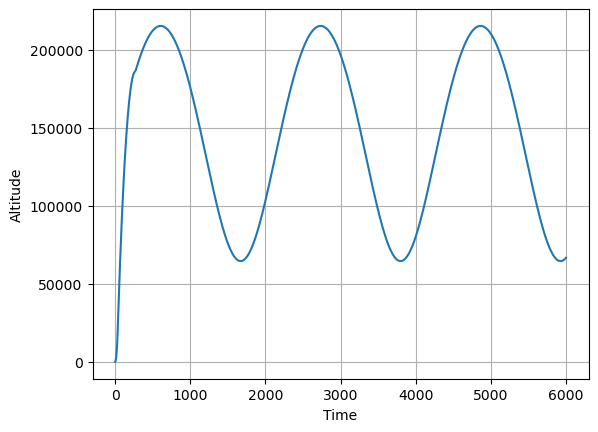

In [4]:
#plot for altitude
plt.plot(tout, altitude)
plt.xlabel("Time")
plt.ylabel("Altitude")
plt.grid()

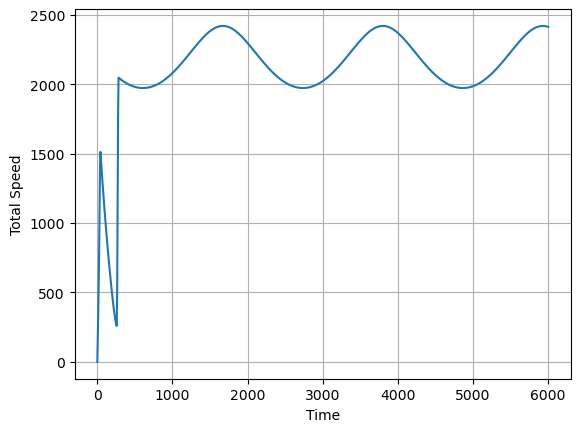

In [5]:
#plot for total speed
plt.plot(tout, velout)
plt.xlabel("Time")
plt.ylabel("Total Speed")
plt.grid()

#both figures give projectile flat earth model

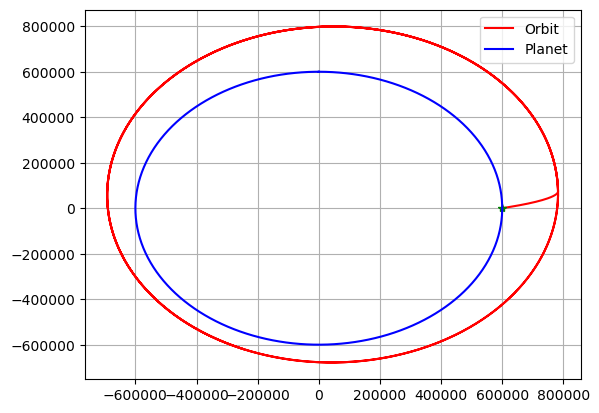

In [6]:
#2D orbit
plt.figure()
plt.plot(xout,zout, "r-", label = "Orbit")
plt.plot(xout[0], zout[0],"g*")
theta = np.linspace(0,2*np.pi, 1000)
xplanet = rplanet*np.sin(theta) #these are parametic equations of a circle
yplanet = rplanet*np.cos(theta)
plt.plot(xplanet, yplanet, "b-", label = "Planet")
plt.grid()
plt.legend()

#this is kepler's second law where the the motion is faster when the object is close to planet forming an elliptical orbit

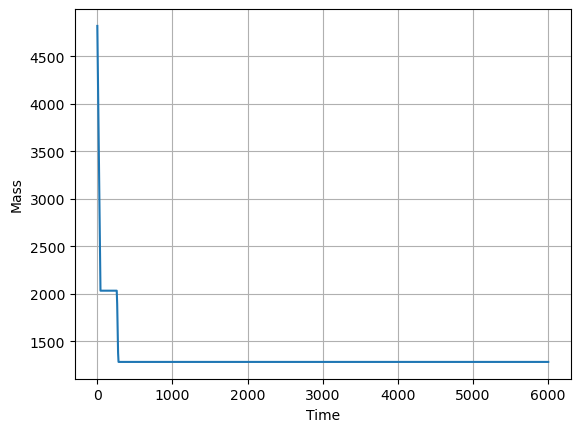

In [7]:
#plot for mass
plt.figure()
plt.plot(tout, massout)
plt.xlabel("Time")
plt.ylabel("Mass")
plt.grid()